# Loading and shapping the data

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images

import warnings
warnings.filterwarnings('ignore')

In [2]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [3]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [4]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

#drop indices column
x_conso=x_conso.drop(columns=x_conso.columns[0],axis=1)

#Visualize data frame head
x_conso.head(5)

,ds,consumption_France,temperature_France,is_holiday_day
0,2012-12-28 00:00:00,59679.0,8.817600,0.0
1,2012-12-28 00:30:00,58103.0,8.690875,0.0
2,2012-12-28 01:00:00,55354.0,8.564150,0.0
3,2012-12-28 01:30:00,55196.0,8.440525,0.0
4,2012-12-28 02:00:00,54324.0,8.316900,0.0


In [5]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

dict_xconso = {'train': x_conso}

# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


In [6]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)
type_x = ['conso']
type_cond = ['temperature', 'month']
dataset_cond = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, list_cond=type_cond)
dataset_cond_emb, to_emb_dim = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, list_cond=type_cond, embedding=True)

temperature (1830, 48)
month (1830, 12)
temperature (1830, 48)
month (1830, 12)
3


In [7]:
dataset_cond_emb['train']['x'][2].shape

(1830, 12)

In [8]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0

In [9]:
#Study conso variations as importance factors
slope = np.abs(np.diff(dataset['train']['x'][0]))
#variationMax = np.max(slope, axis=1)
variationMean = np.mean(slope, axis = 1)
#calendar_info['load_variation_max'] = variationMax
calendar_info['load_variation_mean'] = variationMean

In [10]:
#explicit the potential bridge days taken as extended holidays
day_hol = calendar_info[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

calendar_info['potential_bridge_holiday'] = bridges
calendar_info['potential_bridge_holiday'].describe()

count    1830.000000
mean        0.008743
std         0.093121
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: potential_bridge_holiday, dtype: float64

In [11]:
factors = calendar_info.iloc[:,1:5].copy()
columns_x = x_conso.columns
conso_idx = np.argmax(['consumption' in c for c in x_conso.columns])
temp_idx = np.argmax(['temperature' in c for c in x_conso.columns])
dates = np.unique(x_conso['ds'].dt.date)
temperatureMean=np.asarray([np.mean(x_conso[columns_x[temp_idx]].iloc[np.where(x_conso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

factorMatrix = np.c_[factors.values,temperatureMean,variationMean]

factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'temperature':'regressor',
    'load_delta_mean' : 'regressor'
}

# Tools pour evaluation

In [12]:
#visualisation d'une représentation 2D dans le notebook
from sklearn.decomposition import PCA
def prez_2D(x_encoded):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');

    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

In [13]:
#visualisation des metrics
def display_metrics(model_eval, z_dim, factorDesc):
    if 'reconstruction_error' in model_eval.keys():
        for k,v in model_eval['reconstruction_error'].item():
            print(k,, ' : ', v)
    print('Mutual Information Gap : %.2f'%model_eval['mig'])

    fig = plt.figure(dpi=100,figsize=(10,8))

    plt.subplot(1, 3, 1)
    fig.subplots_adjust(hspace=0.5)
    plt.bar(factorDesc.keys(),model_eval['informativeness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.ylim(top=1)
    for index,data in enumerate(model_eval['informativeness']):
        plt.text(x=index - 0.5, y =data+0.01 , s="%.2f"%data , fontdict=dict(fontsize=10))
    plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']))

    plt.subplot(1, 3, 2)
    plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
    plt.xlabel('latent variables')
    plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

    plt.subplot(1, 3, 3)
    plt.bar(factorDesc.keys(),model_eval['compactness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.title('Compactness')
    plt.tight_layout();

# Setting the options of CVAEs

In [14]:
import CVAE.cvae_model
import CVAE.cvae_model_mixture
import CVAE.cvae_model_cluster
import CVAE.callbacks
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.cvae_model_mixture)
importlib.reload(CVAE.cvae_model_cluster)
importlib.reload(CVAE.callbacks)
from FeaturesScore.scoring import *

%load_ext autoreload
%autoreload

In [15]:
z_dim = 4
e_dims=[48,35,24,12]#encoder dim
d_dims=[48,35,24,12]#decoder dim. Dense Blocks in skip connections can make the dimensions bigger when layers are concatenated with the previous one
lr=3e-4
input_dim = dataset['train']['x'][0].shape[1]

In [16]:
epochs = 800
batch_size = 16

# Experimentation on the size of condtions' embeddings

## 1. Without embedding

In [17]:
name_model = 'cvae_test_without_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond = CVAE.cvae_model.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=dataset_cond['train']['x'][1].shape[1],
                                beta=Beta, is_L2_Loss=False,
                                name=name_model, output=path_out)

Instructions for updating:
Colocations handled automatically by placer.
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 12475       x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample



--- START TRAINING ---

Instructions for updating:
Use tf.cast instead.
[290.93936 261.19943 485.55374 275.21408]
4.524285984375
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.588921  0.167739  0.588629        0.050909     0.859400
random model    0.467709  0.132770  0.092300        0.032727    -0.432838
0 Epochs ...  - loss: 29.1551 - decoder_loss: 27.6127 - decoder_for_kl_loss: 1.5424 - val_loss: 20.1001 - val_decoder_loss: 19.9641 - val_decoder_for_kl_loss: 0.1360 val_loss 20.10006847277365 ... lambda Loss 1.0
[  64.178116   81.471405 1626.3353     66.21945 ]
11.092606437499997
              is_weekday  weekday     month  is_holiday_day  temperature
score model     0.928731  0.37446  0.290429        0.170909     0.209431
random model    0.484445  0.14499  0.080431        0.007273    -0.406705
100 Epochs ...  - loss: 5.3394 - decoder_loss: 3.4847 - decoder_for_kl_loss: 1.8547 - val_loss: 5.6961 - val_decoder_loss: 3.8122 - val_decoder_fo

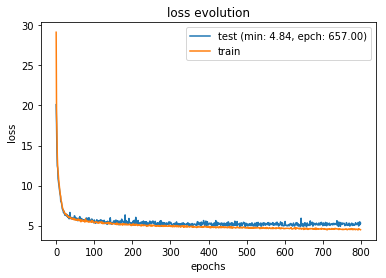

In [18]:
out_batch = NEpochLogger(x_train_data=dataset_cond['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond.main_train(dataset_cond, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [78]:
x_input = dataset_cond['train']['x']

input_encoder = x_input

x_encoded, variance = model_CVAE_cond.encoder.predict(input_encoder)
variance = np.exp(variance)

x_hat = model_CVAE_cond.cvae.predict(x=input_encoder)[0]

In [62]:
stats.describe(np.exp(variance))[1:3]

((array([0.97957885, 0.9810623 , 0.00402782, 0.98045045], dtype=float32),
  array([1.000091  , 0.9988755 , 0.30258763, 1.0078838 ], dtype=float32)),
 array([0.9899096 , 0.99197   , 0.05734065, 0.99634683], dtype=float32))

mean_absolute_error :  2.8687955035971346
mean_squared_error :  0.49705280337052027
Mutual Information Gap : 0.03


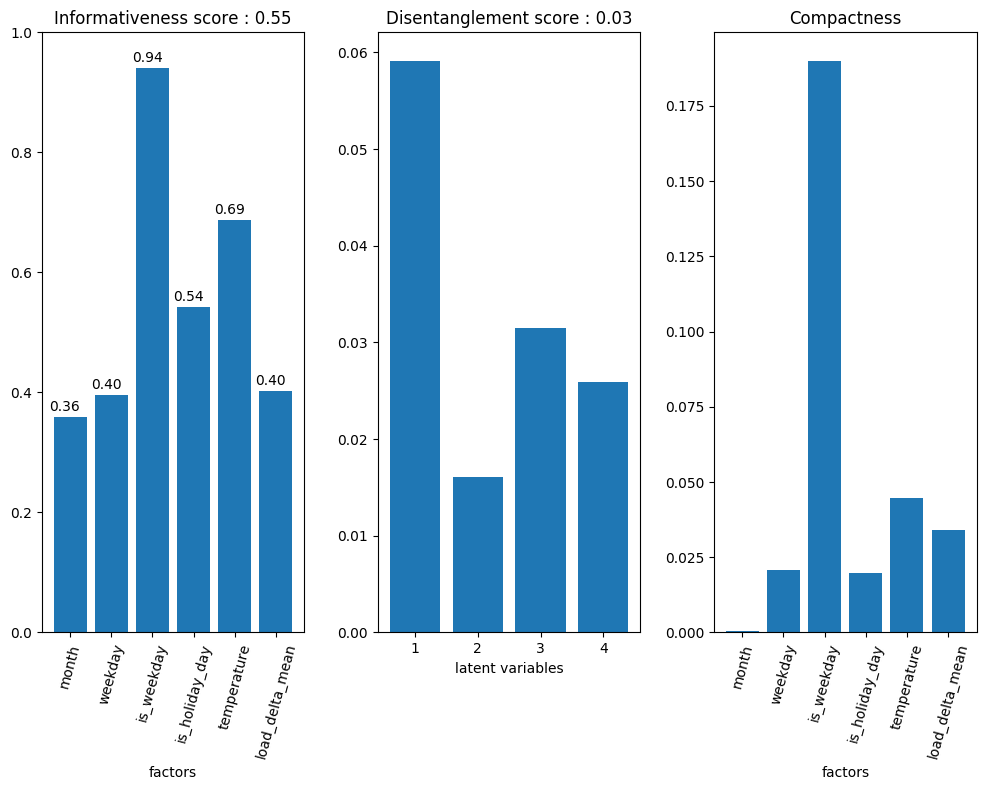

In [27]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

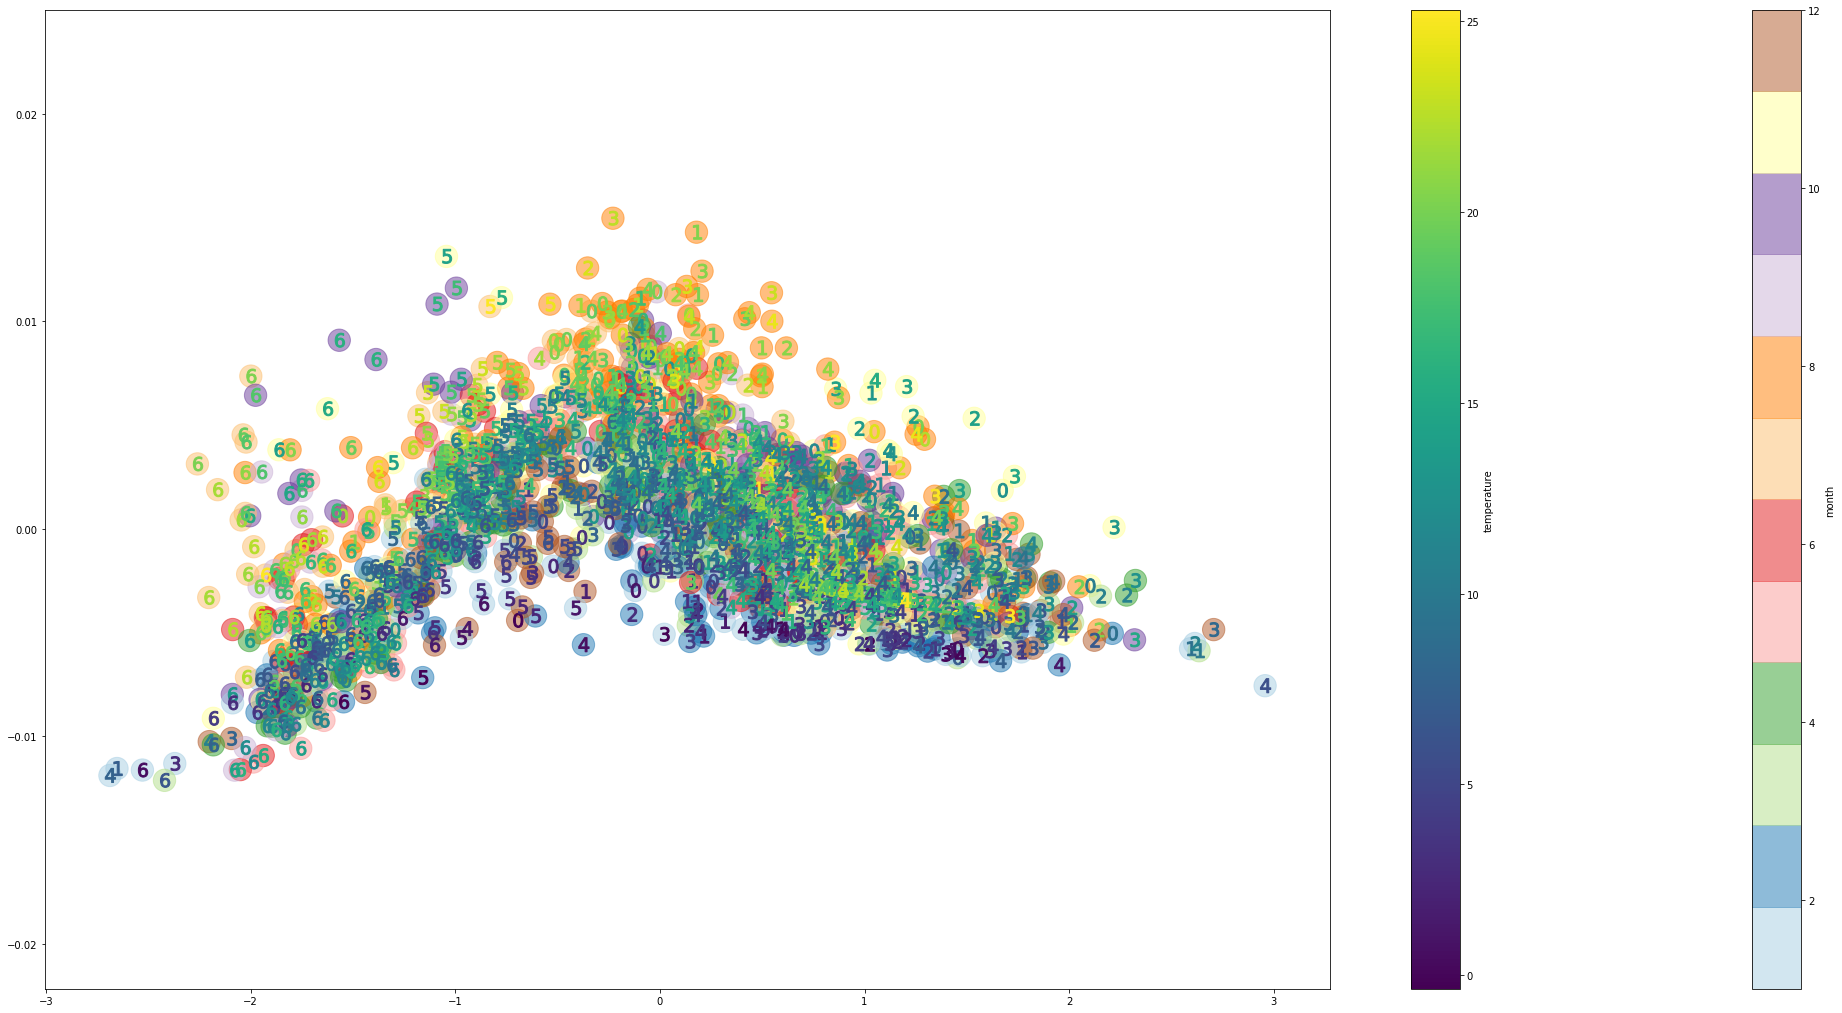

In [28]:
prez_2D(x_encoded)

## Test with embedding

In [83]:
#embeddings conditions
emb_dims=[[12,4],[6,3]]
emb_to_z_dim=[z_dim,z_dim]

In [84]:
name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=0,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

4
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
embedding_enc (Model)           (None, 4)            823         emb_input_0[0][0]                
                                                                 emb_input_1



--- START TRAINING ---

emb_input_0
emb_input_1
[2241.078   2052.2502   947.96924 1501.2169 ]
4.3711261875
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.803012  0.296254  0.403797        0.090909     0.878754
random model    0.501508  0.139887  0.087361        0.021818    -0.434371
0 Epochs ...  - loss: 36.6833 - decoder_loss: 35.3967 - decoder_for_kl_loss: 1.2866 - val_loss: 23.6129 - val_decoder_loss: 20.5594 - val_decoder_for_kl_loss: 3.0535 val_loss 23.612913559043342 ... lambda Loss 1.0
emb_input_0
emb_input_1
[1319.961    120.80613   66.80768  980.081  ]
9.040301286458334
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.959437  0.513697  0.287077        0.225455     0.406147
random model    0.470348  0.152507  0.081931        0.010909    -0.436326
100 Epochs ...  - loss: 6.8086 - decoder_loss: 4.2145 - decoder_for_kl_loss: 2.5941 - val_loss: 6.4053 - val_decoder_loss: 4.0972 - val_decoder_f

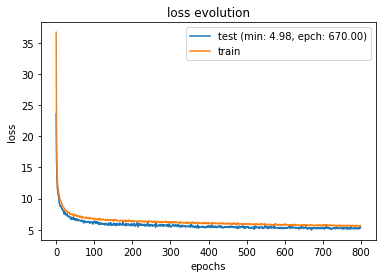

In [85]:
out_batch = NEpochLogger(x_train_data=dataset_cond_emb['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_emb, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [86]:
x_input = dataset_cond_emb['train']['x']
emb_inputs=x_input[1:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset['train']['x'][0], emb_outputs]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


mean_absolute_error :  3.0676251297856503
mean_squared_error :  0.5383797391536541
Mutual Information Gap : 0.16


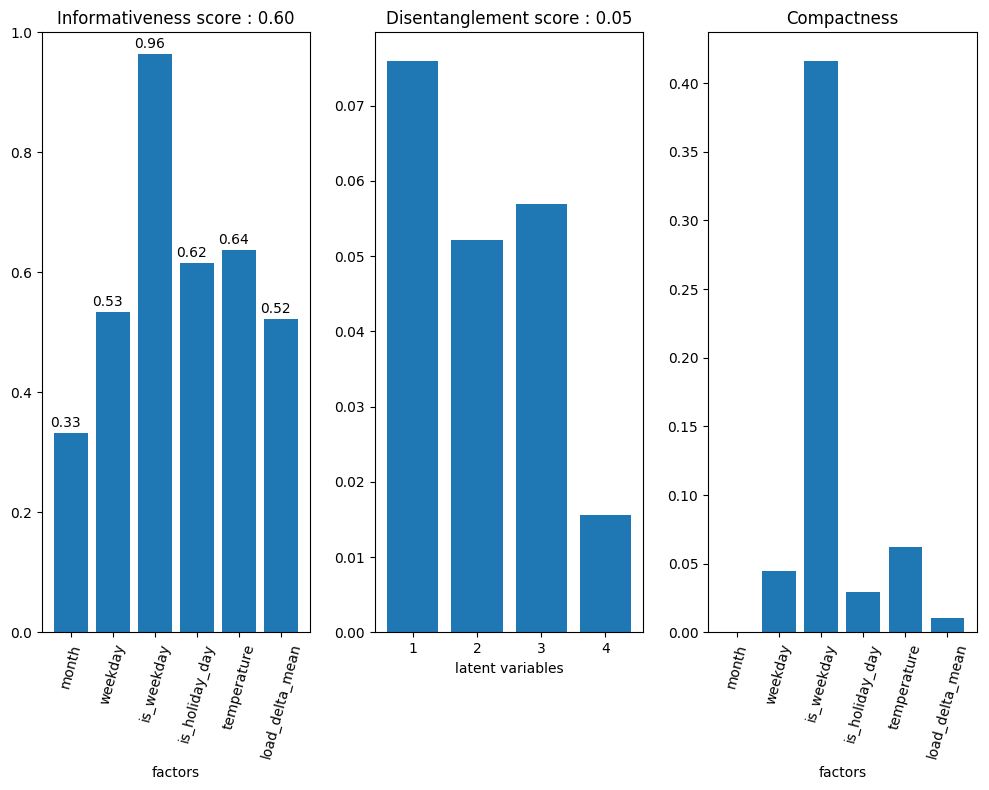

In [87]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

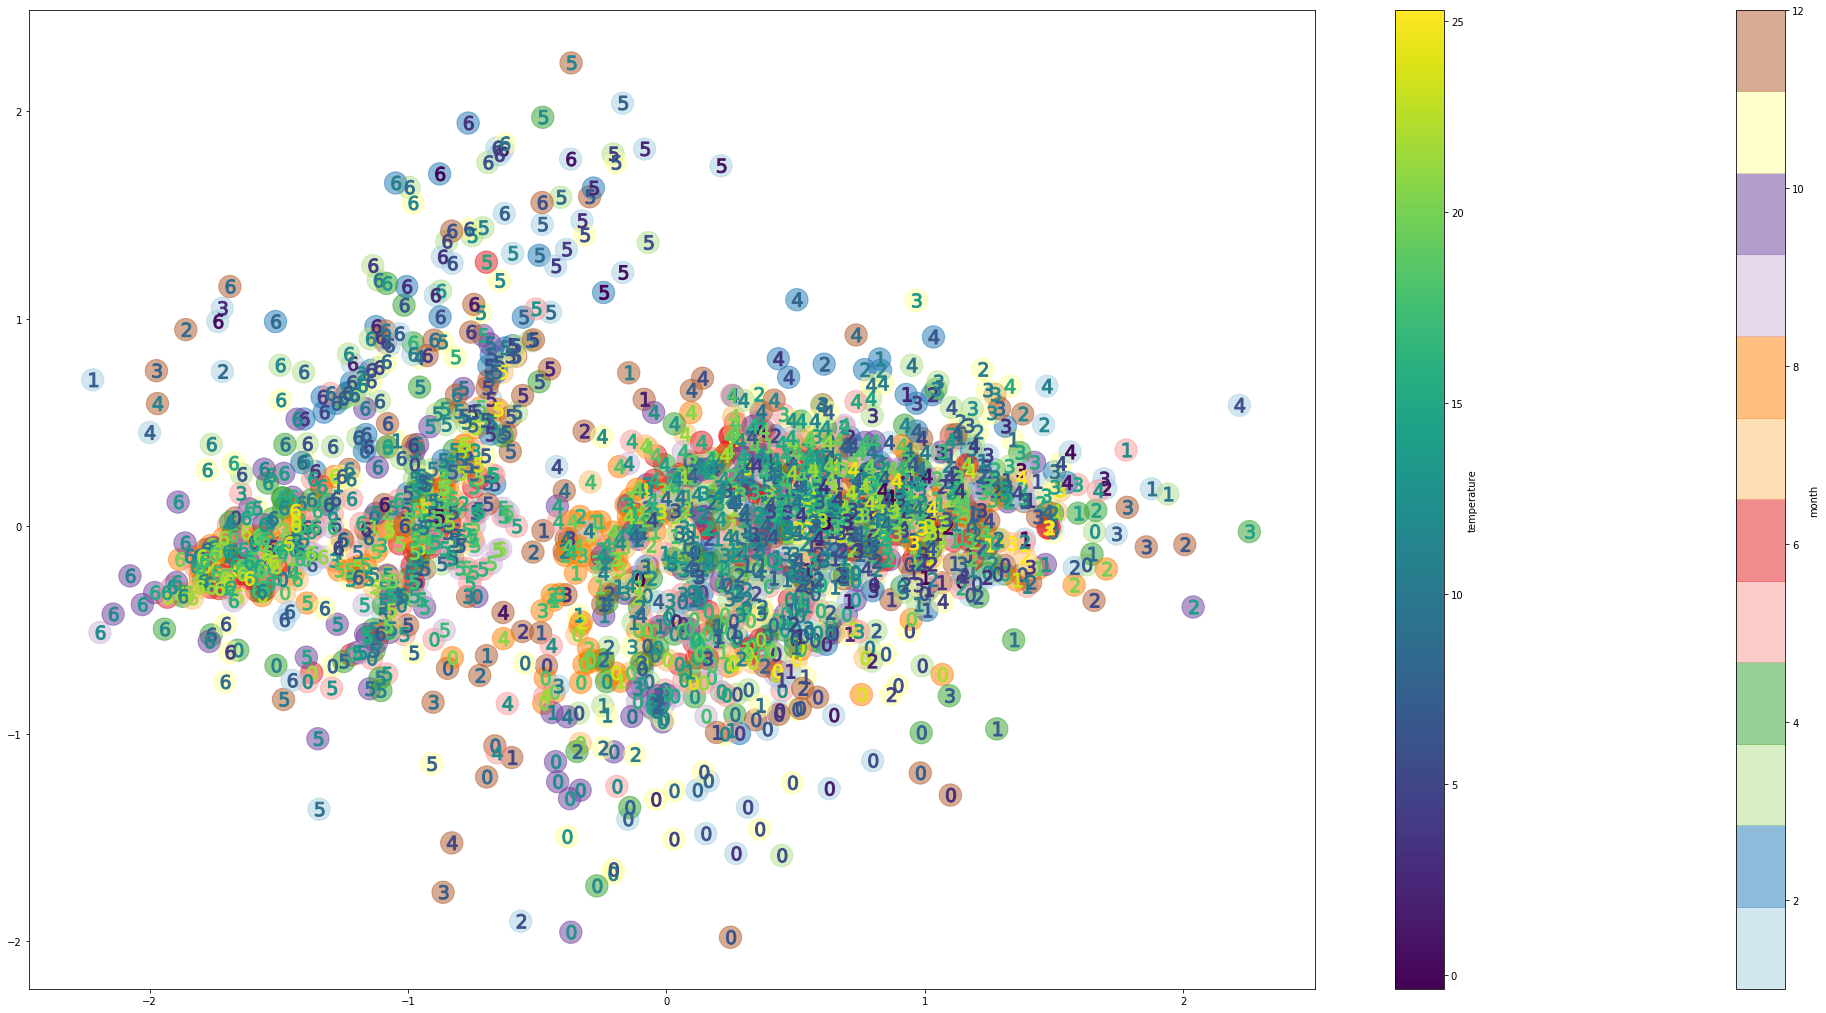

In [88]:
prez_2D(x_encoded)

### Variation de la taille des couches

In [89]:
#just temperature embedding
emb_dims=[[16,8],[]]
emb_to_z_dim=[4,to_emb_dim[1]]

name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=0,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

12
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
embedding_enc (Model)           (None, 12)           1284        emb_input_0[0][0]                
                                                                 emb_input_



--- START TRAINING ---

emb_input_0
emb_input_1
[1110.2499  1684.3506  1395.2053   599.83966]
3.536550098958333
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.749897  0.256418  0.515185        0.105455     0.912846
random model    0.527621  0.156307  0.071099        0.029091    -0.427790
0 Epochs ...  - loss: 36.1499 - decoder_loss: 35.4718 - decoder_for_kl_loss: 0.6782 - val_loss: 26.2444 - val_decoder_loss: 24.2198 - val_decoder_for_kl_loss: 2.0246 val_loss 26.244381732627993 ... lambda Loss 1.0
emb_input_0
emb_input_1
[ 735.024     69.88868 1420.7974    74.50523]
8.793364270833333
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.968603  0.527927  0.309672        0.283636     0.453251
random model    0.460134  0.147922  0.086231        0.014545    -0.409167
100 Epochs ...  - loss: 6.4203 - decoder_loss: 4.0650 - decoder_for_kl_loss: 2.3552 - val_loss: 5.8291 - val_decoder_loss: 3.6245 - val_deco

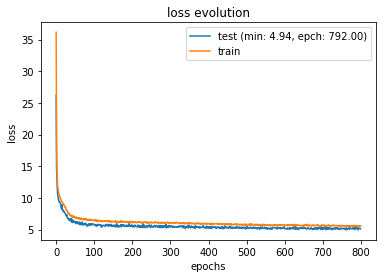

In [90]:
out_batch = NEpochLogger(x_train_data=dataset_cond_emb['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_emb, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [92]:
x_input = dataset_cond_emb['train']['x']
emb_inputs=x_input[1:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset['train']['x'][0], emb_outputs]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


mean_absolute_error :  2.9677347104186698
mean_squared_error :  0.5208470009201024
Mutual Information Gap : 0.14


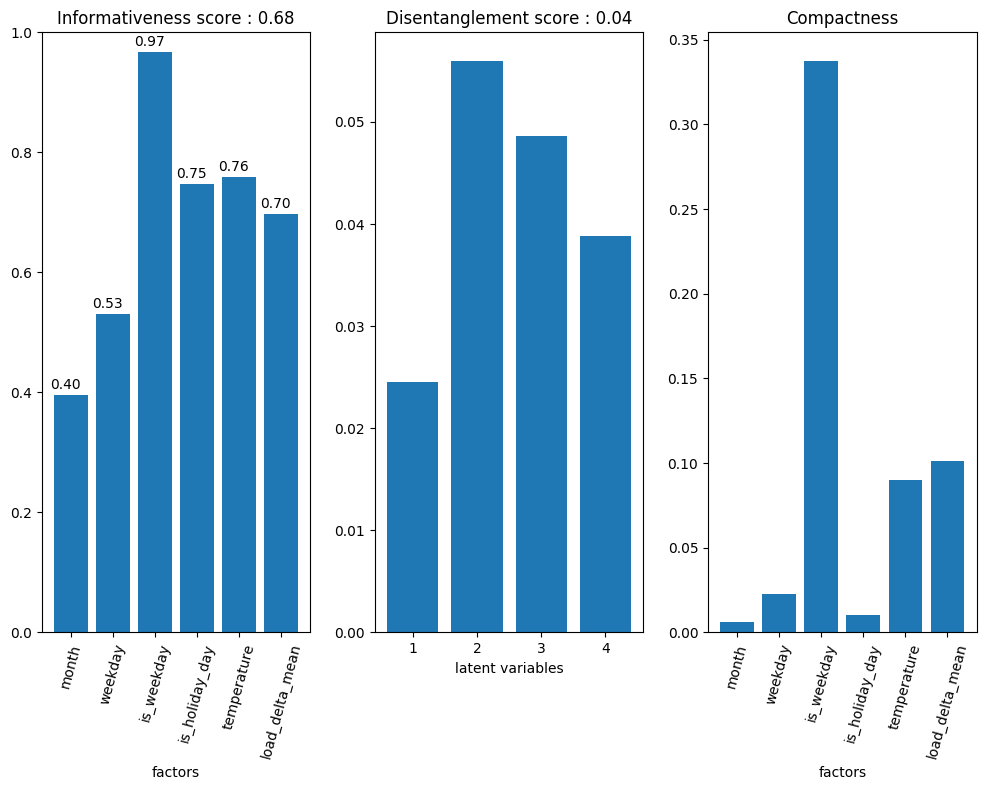

In [93]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

In [94]:
#just month embedding
emb_dims=[[],[9,6]]
emb_to_z_dim=[to_emb_dim[0],4]

name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=0,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

4
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
embedding_enc (Model)           (None, 4)            5573        emb_input_0[0][0]                
                                                                 emb_input_1



--- START TRAINING ---

emb_input_0
emb_input_1
[1571.8993 1131.5153  601.1484 1969.9823]
2.6923791874999994
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.804588  0.300052  0.359224        0.090909     0.946675
random model    0.474598  0.148086  0.085696        0.025455    -0.420680
0 Epochs ...  - loss: 34.1934 - decoder_loss: 33.0841 - decoder_for_kl_loss: 1.1093 - val_loss: 20.4645 - val_decoder_loss: 17.5769 - val_decoder_for_kl_loss: 2.8877 val_loss 20.4645442441513 ... lambda Loss 1.0
emb_input_0
emb_input_1
[ 111.94283 1354.2402   101.60956  721.8727 ]
9.710466937500001
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.963951  0.513732  0.348260        0.210909     0.363845
random model    0.472207  0.149018  0.083068        0.054545    -0.453637
100 Epochs ...  - loss: 6.4809 - decoder_loss: 4.0471 - decoder_for_kl_loss: 2.4338 - val_loss: 5.7142 - val_decoder_loss: 3.6356 - val_decoder_f

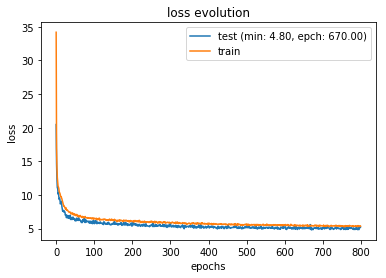

In [95]:
out_batch = NEpochLogger(x_train_data=dataset_cond_emb['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_emb, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [96]:
x_input = dataset_cond_emb['train']['x']
emb_inputs=x_input[1:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset['train']['x'][0], emb_outputs]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


mean_absolute_error :  2.9517302686897904
mean_squared_error :  0.5131893252379317
Mutual Information Gap : 0.13


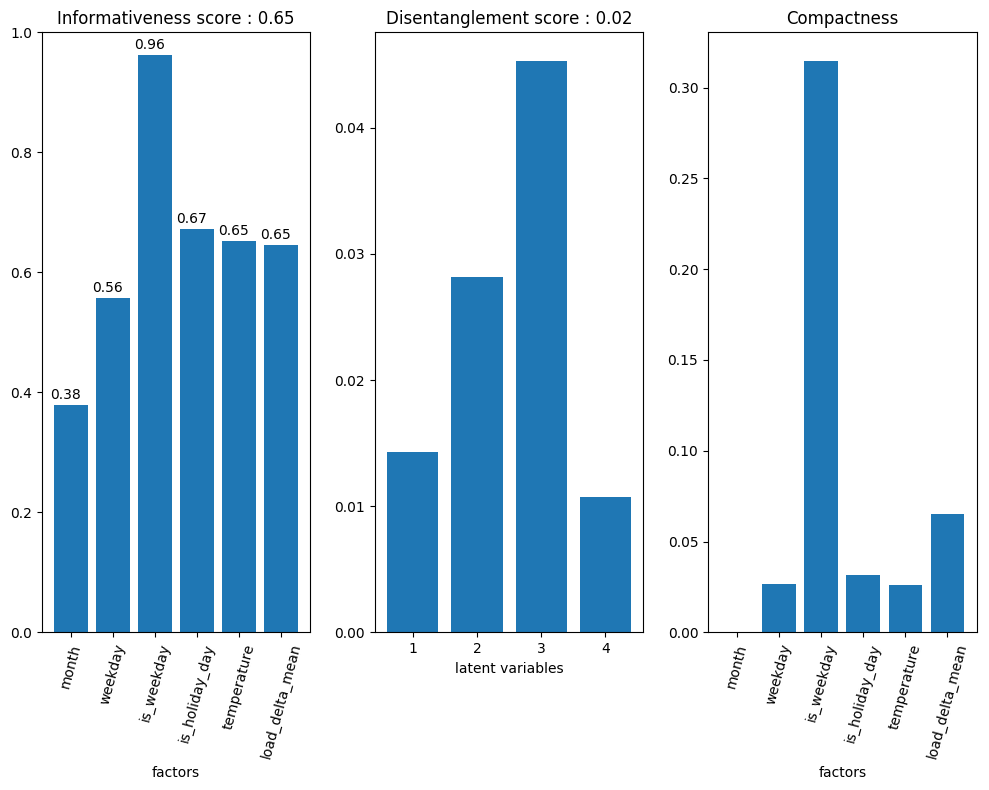

In [97]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

In [98]:
#Both variation
def set_layer_dim(input_dim, output_dim, n_layers):
    hidden = np.linspace(start=output_dim, stop=input_dim, num=n_layers+2,dtype=int)
    return [z for z in hidden[1:n_layers+1][::-1]]
    
print(np.logspace(2,6,num=5,base=2, dtype=int))
print(np.logspace(2,4,num=5,base=2, dtype=int))

[ 4  8 16 32 64]
[ 4  5  8 11 16]


In [99]:
#just month embedding
emb_to_z_dim=[8,5]
emb_dims=[set_layer_dim(48, emb_to_z_dim[0], 2),set_layer_dim(12, emb_to_z_dim[1], 2)]

name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=0,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

5
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
embedding_enc (Model)           (None, 5)            2917        emb_input_0[0][0]                
                                                                 emb_input_1



--- START TRAINING ---

emb_input_0
emb_input_1
[ 925.729   621.3585 2330.4705 2166.5825]
2.8943775885416656
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.795901  0.285645  0.374354        0.105455     0.942838
random model    0.495310  0.126320  0.091175        0.043636    -0.415516
0 Epochs ...  - loss: 33.2083 - decoder_loss: 31.8726 - decoder_for_kl_loss: 1.3357 - val_loss: 21.1388 - val_decoder_loss: 18.4723 - val_decoder_for_kl_loss: 2.6665 val_loss 21.13884581894171 ... lambda Loss 1.0
emb_input_0
emb_input_1
[  78.15571    66.238846 1369.6218     99.94577 ]
10.007539041666666
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.922499  0.395174  0.369815        0.156364     0.300506
random model    0.497534  0.139259  0.089662        0.032727    -0.425981
100 Epochs ...  - loss: 6.6742 - decoder_loss: 4.6381 - decoder_for_kl_loss: 2.0361 - val_loss: 5.9544 - val_decoder_loss: 4.1170 - val_dec

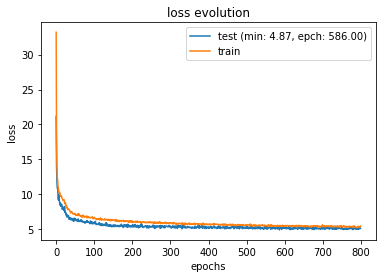

In [100]:
out_batch = NEpochLogger(x_train_data=dataset_cond_emb['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_emb, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [101]:
x_input = dataset_cond_emb['train']['x']
emb_inputs=x_input[1:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset['train']['x'][0], emb_outputs]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


mean_absolute_error :  3.0070368432148595
mean_squared_error :  0.5279801597792269
Mutual Information Gap : 0.10


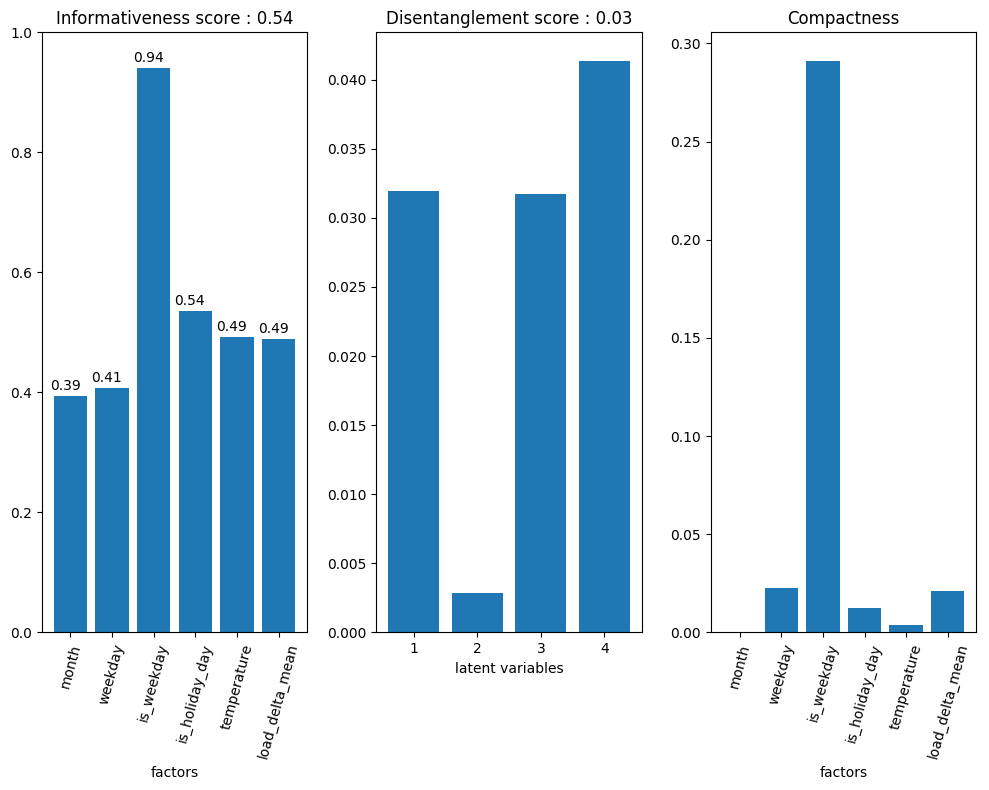

In [102]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

In [103]:
#just month embedding
emb_to_z_dim=[16,8]
emb_dims=[set_layer_dim(48, emb_to_z_dim[0], 2),set_layer_dim(12, emb_to_z_dim[1], 2)]

name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=0,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

8
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
embedding_enc (Model)           (None, 8)            3838        emb_input_0[0][0]                
                                                                 emb_input_1



--- START TRAINING ---

emb_input_0
emb_input_1
[ 722.2969   647.02295  187.82208 1403.5422 ]
3.502334828125001
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.767194  0.267236  0.366760        0.105455     0.919557
random model    0.498114  0.124045  0.081195        0.040000    -0.427112
0 Epochs ...  - loss: 34.1029 - decoder_loss: 33.5404 - decoder_for_kl_loss: 0.5625 - val_loss: 22.8179 - val_decoder_loss: 21.8098 - val_decoder_for_kl_loss: 1.0081 val_loss 22.81787357434549 ... lambda Loss 1.0
emb_input_0
emb_input_1
[ 185.27573  252.26103  108.66    1367.158  ]
8.210724109375
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.964196  0.471016  0.317564        0.189091     0.546230
random model    0.466779  0.159148  0.085697        0.043636    -0.426594
100 Epochs ...  - loss: 6.2432 - decoder_loss: 4.1230 - decoder_for_kl_loss: 2.1201 - val_loss: 5.7356 - val_decoder_loss: 3.8413 - val_decoder_

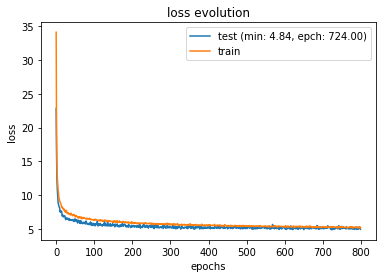

In [104]:
out_batch = NEpochLogger(x_train_data=dataset_cond_emb['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_emb, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [105]:
x_input = dataset_cond_emb['train']['x']
emb_inputs=x_input[1:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset['train']['x'][0], emb_outputs]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


mean_absolute_error :  2.9987128889216454
mean_squared_error :  0.5182172218322111
Mutual Information Gap : 0.19


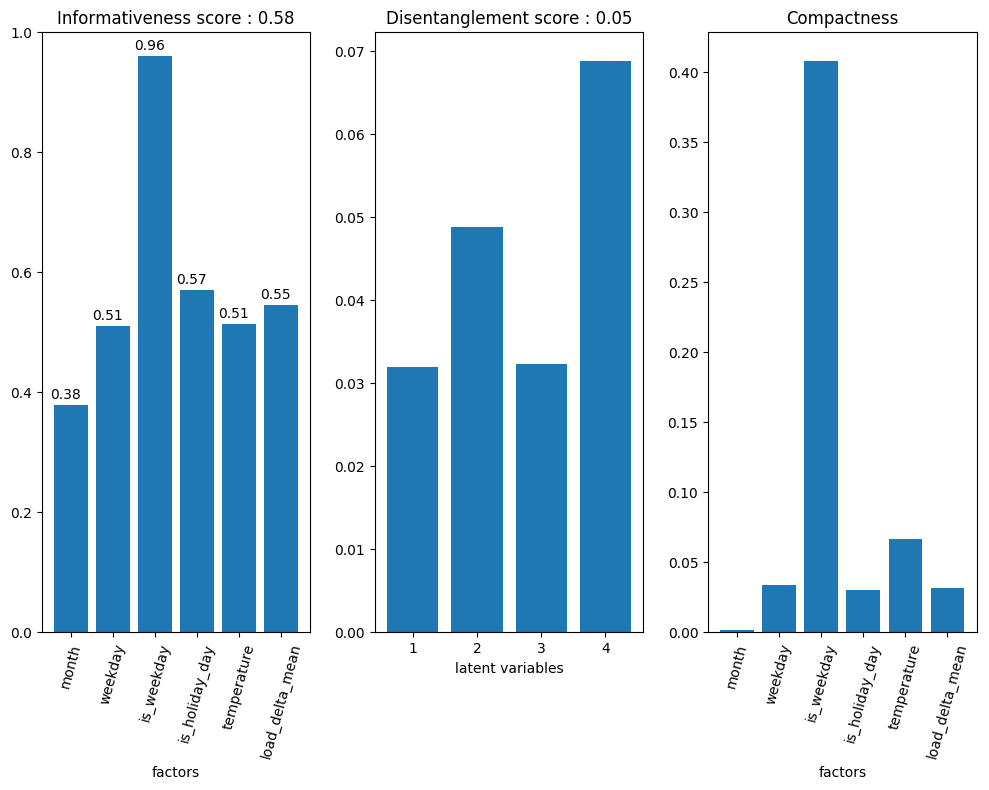

In [106]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

In [107]:
#just month embedding
emb_to_z_dim=[32,10]
emb_dims=[set_layer_dim(48, emb_to_z_dim[0], 2),set_layer_dim(12, emb_to_z_dim[1], 2)]

name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=0,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

10
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
embedding_enc (Model)           (None, 10)           5946        emb_input_0[0][0]                
                                                                 emb_input_



--- START TRAINING ---

emb_input_0
emb_input_1
[869.581   245.95773 705.1844  953.84827]
1.6865383489583332
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.807622  0.302688  0.465983        0.061818     0.976854
random model    0.487320  0.138178  0.086312        0.043636    -0.403036
0 Epochs ...  - loss: 33.1511 - decoder_loss: 32.5861 - decoder_for_kl_loss: 0.5650 - val_loss: 22.5268 - val_decoder_loss: 21.4821 - val_decoder_for_kl_loss: 1.0448 val_loss 22.526839449106017 ... lambda Loss 1.0
emb_input_0
emb_input_1
[1336.8308    73.7422    69.17134  811.3718 ]
10.614953598958333
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.971728  0.541484  0.252836        0.305455     0.222722
random model    0.472353  0.152970  0.081940        0.036364    -0.406666
100 Epochs ...  - loss: 6.1538 - decoder_loss: 3.7378 - decoder_for_kl_loss: 2.4159 - val_loss: 5.5140 - val_decoder_loss: 3.3282 - val_decode

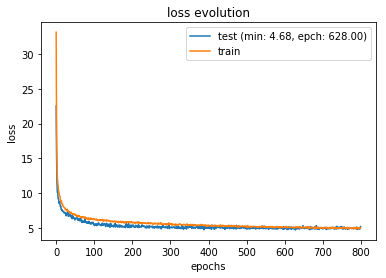

In [108]:
out_batch = NEpochLogger(x_train_data=dataset_cond_emb['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_emb, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [109]:
x_input = dataset_cond_emb['train']['x']
emb_inputs=x_input[1:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset['train']['x'][0], emb_outputs]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


mean_absolute_error :  2.9922784404188327
mean_squared_error :  0.5106617739064241
Mutual Information Gap : 0.16


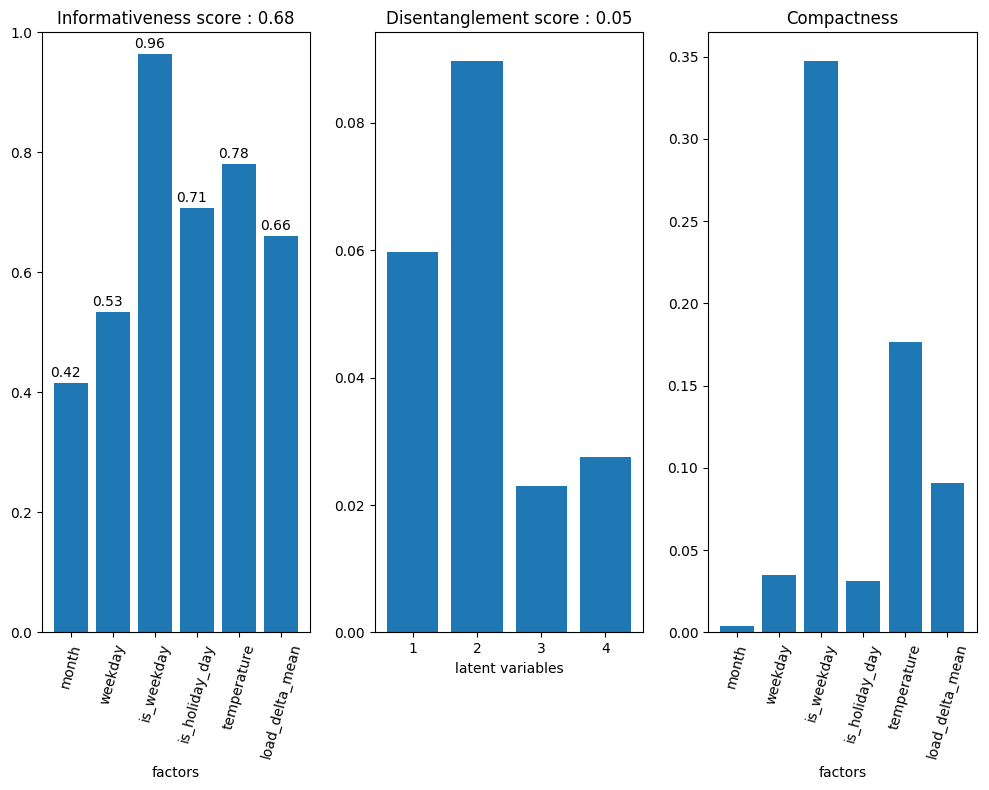

In [110]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

In [111]:
#just month embedding
emb_to_z_dim=[2,2]
emb_dims=[set_layer_dim(48, emb_to_z_dim[0], 2),set_layer_dim(12, emb_to_z_dim[1], 2)]

name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=0,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

2
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
embedding_enc (Model)           (None, 2)            2346        emb_input_0[0][0]                
                                                                 emb_input_1



--- START TRAINING ---

emb_input_0
emb_input_1
[1760.6919  312.9597  766.7915 1021.0549]
4.030682031249999
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.882954  0.358630  0.421294        0.109091     0.879428
random model    0.480464  0.128247  0.077417        0.036364    -0.455737
0 Epochs ...  - loss: 37.5001 - decoder_loss: 36.9415 - decoder_for_kl_loss: 0.5586 - val_loss: 30.1462 - val_decoder_loss: 28.5837 - val_decoder_for_kl_loss: 1.5625 val_loss 30.146227487449437 ... lambda Loss 1.0
emb_input_0
emb_input_1
[1362.127     873.30164    51.652885   79.40247 ]
9.507045942708334
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.961530  0.477191  0.258044        0.189091     0.387103
random model    0.470747  0.147010  0.079089        0.014545    -0.420096
100 Epochs ...  - loss: 6.8183 - decoder_loss: 4.2899 - decoder_for_kl_loss: 2.5284 - val_loss: 6.5013 - val_decoder_loss: 4.3964 - val_deco

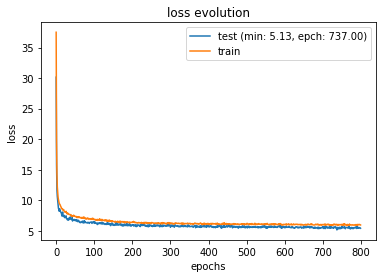

In [112]:
out_batch = NEpochLogger(x_train_data=dataset_cond_emb['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_emb, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [113]:
x_input = dataset_cond_emb['train']['x']
emb_inputs=x_input[1:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset['train']['x'][0], emb_outputs]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


mean_absolute_error :  3.34334054077181
mean_squared_error :  0.5932268688573752
Mutual Information Gap : 0.17


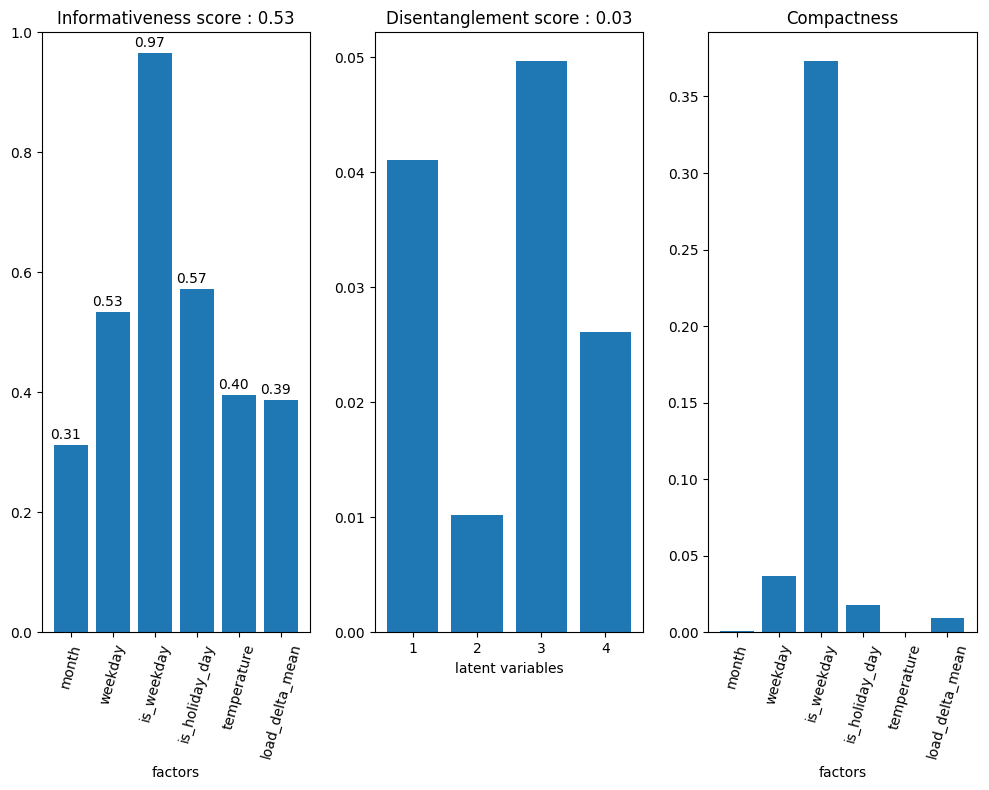

In [114]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)